(content:references:spectra_part3)=
# Stellar Spectra Part 3: *The Payne*

***Author: Marc Hon***

In [](content:references:spectra_part2), we explored a data-driven approach to stellar parameter determination by considering the flux at each wavelength/pixel as a quadratic function of stellar labels. Here, we will explore an extension of this approach called *The Payne*, in which the flux is modeled as a general non-linear function of the stellar labels, learned using a neural network. This allows for more complex label–flux relationships to be captured.   


In the following, we will explore the framework of *The Payne* model based on the code and tutorial provided [here](https://github.com/tingyuansen/The_Payne). 

```{note}
The name of *The Payne* is inspired by the astronomer [Cecilia Payne-Gaposchkin](https://en.wikipedia.org/wiki/Cecilia_Payne-Gaposchkin), who is responsible for our modern understanding of the spectral sequence, and that of the chemical makeup of stars being comprised mostly of hydrogen and helium.
```


## Network architecture

*The Payne*, at its [inception](https://iopscience.iop.org/article/10.3847/1538-4357/ab2331/pdf), deploys a simple neural network architecture comprising two fully connected layers. Mathematically, this is represented as 

$$
f_\lambda = W^{[2]} \cdot \phi \left( W^{[1]} \, \phi \left( W^{[0]} \, \boldsymbol{\ell} + \mathbf{b}^{[0]} \right) + \mathbf{b}^{[1]} \right) + \bar{f}_\lambda,
$$

where:
- $ f_\lambda $: is the flux value at wavelength $ \lambda $,
- $ \boldsymbol{\ell} = (\ell_1, \ell_2, \ldots, \ell_k) $ are the input stellar labels,
- $ \phi(x)$ is a non-linear activation function (defined as `LeakyReLU` in the implementation)
- $ \mathbf{w}^k_{\lambda j}, b_{\lambda j} $: weights and biases of the first hidden layer,
- $ \mathbf{w}^\lambda_j, \tilde{b} $: weights and bias of the second hidden layer,
- $ W^{[i]} $ and $ \mathbf{b}^{[i]} $ are weights and biases at layer $ i $,
- $ \mathbf{w} $: output weights,
- $ \bar{f}_\lambda $: mean spectrum value at wavelength $ \lambda $,


and the Einstein summation convention is assumed over repeated indices $ j $ and $ k $.


```{figure} images/payne.png
---
height: 75px
width: 650px
name: paynemodel1
---
A schematic of a model of *The Payne*. The length of each block represents the number of neurons in that layer.
```

In the following, we will load a pre-trained model of *The Payne*, structured as the following:


In [1]:
import os
import corner
import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec

from pathlib import Path
from astropy.io import fits
from matplotlib import cm
from matplotlib.colors import Normalize
from copy import deepcopy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from The_Payne.training import Payne_model
from torchinfo import summary

data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter2' / 'data'

plt.style.use('science')

fs = 18
dim_in = 25
num_neurons = 300
num_steps=1e4
num_features = 64*5
mask_size=11
num_pixel=7214

model = Payne_model(dim_in, num_neurons, num_features, mask_size, num_pixel)
summary(model, input_size=(1, dim_in))

Layer (type:depth-idx)                   Output Shape              Param #
Payne_model                              [1, 7214]                 --
├─Sequential: 1-1                        [1, 7214]                 --
│    └─Linear: 2-1                       [1, 300]                  7,800
│    └─LeakyReLU: 2-2                    [1, 300]                  --
│    └─Linear: 2-3                       [1, 300]                  90,300
│    └─LeakyReLU: 2-4                    [1, 300]                  --
│    └─Linear: 2-5                       [1, 7214]                 2,171,414
Total params: 2,269,514
Trainable params: 2,269,514
Non-trainable params: 0
Total mult-adds (M): 2.27
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 9.08
Estimated Total Size (MB): 9.14

Let's begin by loading the necessary tools and utilities associated with the library. Similar to *The Cannon*, we will explore this method using data from The Apache Point Observatory Galactic Evolution Experiment (**APOGEE**). Recall that this will be spectra in the H-band (15200–16900 Å) with gaps between 15781-15892 Å and 16405-16510 Å.

In [2]:
from The_Payne import utils
from The_Payne import spectral_model
from The_Payne import fitting


wavelength = utils.load_wavelength_array()  # APOGEE wavelength array
mask = utils.load_apogee_mask()  # Mask indicating Gaps in APOGEE spectra

Because the default network comprises a simple two-layer perceptron, their weights and biases $(\mathbf{w}, b)$ can easily be saved and loaded as individual `numpy` arrays.

In [3]:
NN_coeffs = utils.read_in_neural_network()
w_array_0, w_array_1, w_array_2, b_array_0, \
b_array_1, b_array_2, x_min, x_max = NN_coeffs

Due to this simplicity, inference from the network can simply be performed by 

```
    inside = np.einsum('ij,j->i', w_array_0, scaled_labels) + b_array_0
    outside = np.einsum('ij,j->i', w_array_1, leaky_relu(inside)) + b_array_1
    spectrum = np.einsum('ij,j->i', w_array_2, leaky_relu(outside)) + b_array_2
```

## Label Interpolation with *The Payne*

The network accepts a vector of 26 labels comprising global stellar parameters and individual abundances. 

```{admonition} Additional Free Parameters
:class: tip
The `RV` parameter describes **radial velocity** measurements, which simply serve to shift the observed spectrum's wavelengths to the laboratory rest frame or vice versa.

The `Vturb` parameter measures **microturbulence**, or small-scale turbulent motion in the stellar atmosphere. This effect broadens strong (saturated) spectral lines and is treated as a free parameter to match line depths. 

The `Vmacro` parameter measures **macroturbulence**, large-scale photospheric turbulence. This effect primarily broadens weak and moderate spectral lines. 

The `C12/C13` parameter is the **Carbon Isotopic Ratio**, which traces internal mixing and can be a proxy for stellar evolution. This parameter affects molecular bands, like CN and CO. 

```

In [17]:
label_names = [
    "Teff", "Logg", "Vturb",
    "[C/H]", "[N/H]", "[O/H]", "[Na/H]", "[Mg/H]",
    "[Al/H]", "[Si/H]", "[P/H]", "[S/H]", "[K/H]",
    "[Ca/H]", "[Ti/H]", "[V/H]", "[Cr/H]", "[Mn/H]",
    "[Fe/H]", "[Co/H]", "[Ni/H]", "[Cu/H]", "[Ge/H]",
    "C12/C13", "Vmacro", "RV"
]

labels  = [5770, 4.04, 1.0,\
            0., 0., 0., 0., 0.,\
            0., 0., 0., 0., 0.,\
            0., 0., 0., 0., 0.,\
            -1.5, 0., 0., 0., 0.,\
            90., 6., 3]

real_label_dict = dict(zip(label_names, labels))

In [18]:
def vary_label(idx):
    label_to_vary = label_names[idx]
    x_range = np.linspace(x_min[idx], x_max[idx], 5)
    plt.figure(figsize=(10, 4))

    for xval in x_range:
        label_dict = deepcopy(real_label_dict)
        label_dict[label_to_vary] = xval
        label_array = np.array([label_dict[key] for key in label_names])
        label_array[:-1] = (label_array[:-1] - x_min) / (x_max - x_min) - 0.5

        # Generate model spectrum
        spec = spectral_model.get_spectrum_from_neural_net(
            scaled_labels=label_array[:-1], NN_coeffs=NN_coeffs)
        spec = utils.doppler_shift(wavelength, spec, label_array[-1])

        plt.plot(wavelength, spec, lw=0.5, label=f"{label_to_vary}= {xval:.2f} dex")
        
    lambda_min, lambda_max = 16000, 16150
    plt.xlim(lambda_min, lambda_max); plt.ylim(0.7, 1.05)
    plt.legend(framealpha=1, frameon=1)
    plt.ylabel('Flux', fontsize=fs)
    plt.xlabel('Wavelength ($\AA$)', fontsize=fs)  

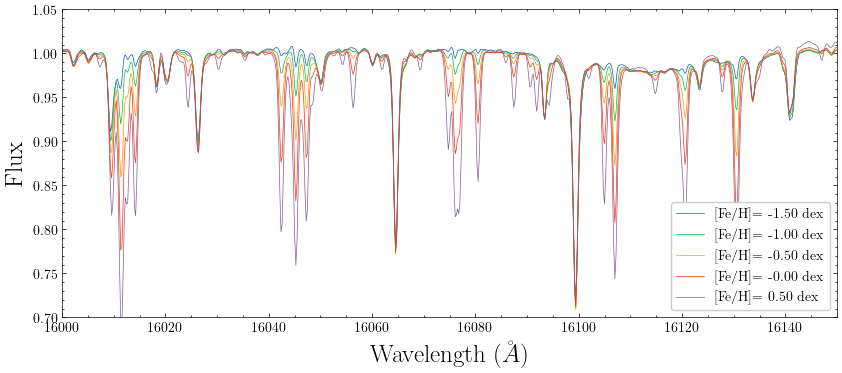

In [19]:
idx = 18
vary_label(idx)

```{admonition} Finding particular spectral lines
:class: tip
Vary the labels using the index `idx` above. Can you identify which elements are primarily responsible for:

- The absorption line at $\sim16010$ Å?
- The absorption line at $\sim16100$ Å?
```

## Sensitivity Analysis

The simple form of *The Payne* allows us to manually calculate the sensitivity of the predicted flux $f_{\lambda}$ to input labels $\boldsymbol{\ell}$. To first order, this can be done by examining first derivatives by computing the Jacobian matrix:

$$
J_{\lambda j} = \frac{\partial f_\lambda}{\partial \ell_j}
$$

where:
- $ f_\lambda $: model-predicted flux at wavelength $ \lambda $,
- $ \ell_j $: input label (scaled),
- $ J \in \mathbb{R}^{N_{\text{wavelengths}} \times N_{\text{labels}}} $.

The quantity $\frac{\partial f_\lambda}{\partial \ell_j}$ can be determined by manually applying the chain rule through the layers of a 2-layer neural network.

Given input label vector $ \boldsymbol{\ell} \in \mathbb{R}^L $, the forward pass is:

$$
\begin{aligned}
\mathbf{z}^{[1]} &= W^{[0]} \boldsymbol{\ell} + \mathbf{b}^{[0]} \\
\mathbf{a}^{[1]} &= \phi(\mathbf{z}^{[1]}) \\
\mathbf{z}^{[2]} &= W^{[1]} \mathbf{a}^{[1]} + \mathbf{b}^{[1]} \\
\mathbf{a}^{[2]} &= \phi(\mathbf{z}^{[2]}) \\
\mathbf{f} &= W^{[2]} \mathbf{a}^{[2]} + \mathbf{b}^{[2]}
\end{aligned}
$$

As before:
- $ \phi $ is Leaky ReLU,
- $ W^{[i]} $ and $ \mathbf{b}^{[i]} $ are weights and biases at layer $ i $.

---

### Applying the Chain Rule Step-by-Step

For each label $ \ell_j $, compute the gradient of the output flux $f_{\lambda}$ with respect to that label.

$$
\frac{\partial f_\lambda}{\partial \ell_j} = \sum_k W^{[2]}_{\lambda k} \cdot \frac{\partial a_k^{[2]}}{\partial \ell_j}
$$

To obtain $\frac{\partial a_k^{[2]}}{\partial \ell_j}$, see that:

$$
\quad
\frac{\partial a_k^{[2]}}{\partial \ell_j} = \phi'(z_k^{[2]}) \cdot \frac{\partial z_k^{[2]}}{\partial \ell_j}
\quad \text{and} \quad
\frac{\partial z_k^{[2]}}{\partial \ell_j} = \sum_m W^{[1]}_{k m} \cdot \frac{\partial a_m^{[1]}}{\partial \ell_j}
$$

Then for $\frac{\partial a_m^{[1]}}{\partial \ell_j}$:

$$
\frac{\partial a_m^{[1]}}{\partial \ell_j} = \phi'(z_m^{[1]}) \cdot W^{[0]}_{m j}
\quad \text{, where} \quad
\frac{\partial z_m^{[1]}}{\partial \ell_j} = W^{[0]}_{m j}
$$

Putting it all together:

$$
\boxed{
\frac{\partial f_\lambda}{\partial \ell_j} =
\sum_{k, m}
W^{[2]}_{\lambda k} \cdot \phi'(z_k^{[2]}) \cdot W^{[1]}_{k m} \cdot \phi'(z_m^{[1]}) \cdot W^{[0]}_{m j}
}
$$

---

This gives the sensitivity of each output flux to each input label in a fully connected feed-forward network with two hidden layers. This can be implemented by the following:


In [20]:
def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_deriv(x, alpha=0.01):
    return np.where(x > 0, 1.0, alpha)

def jacobian(scaled_labels, NN_coeffs):
    w0, w1, w2, b0, b1, b2, *_ = NN_coeffs

    # Forward pass
    z1 = w0 @ scaled_labels + b0            # shape (H1,)
    a1 = leaky_relu(z1)                     # shape (H1,)
    z2 = w1 @ a1 + b1                       # shape (H2,)
    a2 = leaky_relu(z2)                     # shape (H2,)
    spectrum = w2 @ a2 + b2                 # shape (N,)

    # Backward pass (Jacobian), note that N is number of wavelength bins, L is number of labels
    L = len(scaled_labels)
    N = len(spectrum)
    H1 = len(z1)
    H2 = len(z2)
    J = np.zeros((N, L))                    

    # Derivatives
    da2_dz2 = leaky_relu_deriv(z2)          # shape (H2,)
    da1_dz1 = leaky_relu_deriv(z1)          # shape (H1,)

    # Chain rule
    for elle in range(L):  # for each label
        # ∂z1/∂ℓ_j = w0[:, j]                 → shape (H1,)
        dz1_dl = w0[:, elle]
        da1_dl = da1_dz1 * dz1_dl                 # shape (H1,)
        dz2_dl = (w1 @ da1_dl)                    # shape (H2,)
        da2_dl = da2_dz2 * dz2_dl                 # shape (H2,)
        J[:, elle] = w2 @ da2_dl                  # shape (N,)

    return J  # shape (N_wavelengths, N_labels)

```{admonition} Python operator for matrix multiplication
:class: tip

`np.einsum('ij,j->i', A, x)` performs a matrix–vector multiplication, by computing the dot product of each row of matrix A with vector x. It is equivalent to `np.dot(A,x)` and `A @ x` in this scenario.

```

Let's visualize the sensitivity of *The Payne*'s prediction from our previous example. It should be much easier to observe which lines are sensitive to which element now!

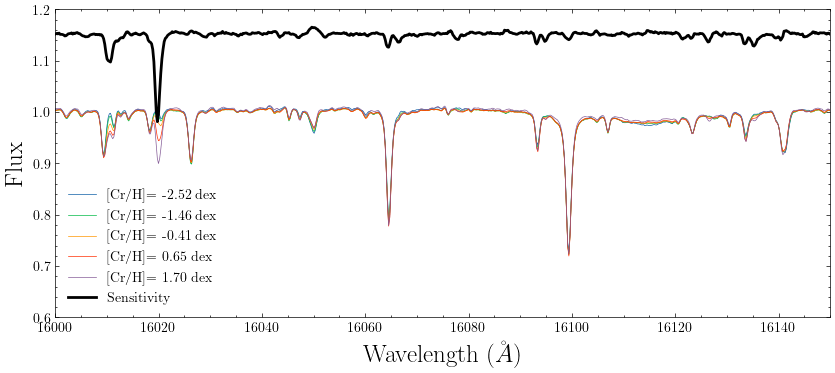

In [26]:
idx = 16
vary_label(idx)

jay = jacobian(scaled_labels=((labels[:-1] - x_min) / (x_max - x_min) - 0.5), 
               NN_coeffs=NN_coeffs)

plt.plot(wavelength, 1.15+jay[:, idx], lw=2, c='k', label='Sensitivity')  # Add with 1 to scale it to the spectrum
plt.ylim(0.6, 1.2); plt.legend();plt.show()


## Emulation with *The Payne*

As a generative model (i.e., an emulator), *The Payne* infers stellar parameters and chemical abundances by fitting emulated spectra to observed data. In this codebase, the fitting process is performed using $\chi^2$ minimization, aiming to match the predicted flux to the observed data across all wavelengths.
```{note} 
$\chi^2$ minimization is the default technique used to infer stellar parameters and abundances in this implementation of *The Payne*. This procedure jointly optimizes all labels in a single pass. In contrast, the APOGEE pipeline (*ASPCAP*: [The APOGEE Stellar Parameter and Chemical Abundances Pipeline](https://iopscience.iop.org/article/10.3847/0004-6256/151/6/144/pdf)) performs the label inference in multiple stages, first determining stellar parameters and then deriving individual element abundances in a more **iterative** fashion.

Although $\chi^2$ minimization is used here, *The Payne*'s formulation as a fast forward model makes it naturally compatible with **Bayesian inference** techniques, including sampling-based methods such as **Markov Chain Monte Carlo (MCMC)** as discussed in [](content:references:transits_part3).

```
Let's examine the emulation of the approach on some validation data. 

In [27]:
training_labels, training_spectra, \
validation_labels, validation_spectra = utils.load_training_data()

The fitting function returns the best fit (`popt`), the error (`pstd`) as the square root of the diagonal of the covariance matrix, and the emulated spectrum of the best fit.

In [28]:
idx = 150
popt, pstd, model_spec = fitting.fit_normalized_spectrum_single_star_model(\
                                norm_spec = validation_spectra[idx], spec_err = 1e-2*np.ones(len(wavelength)),\
                                NN_coeffs = NN_coeffs, wavelength = wavelength, mask=mask, p0 = None)

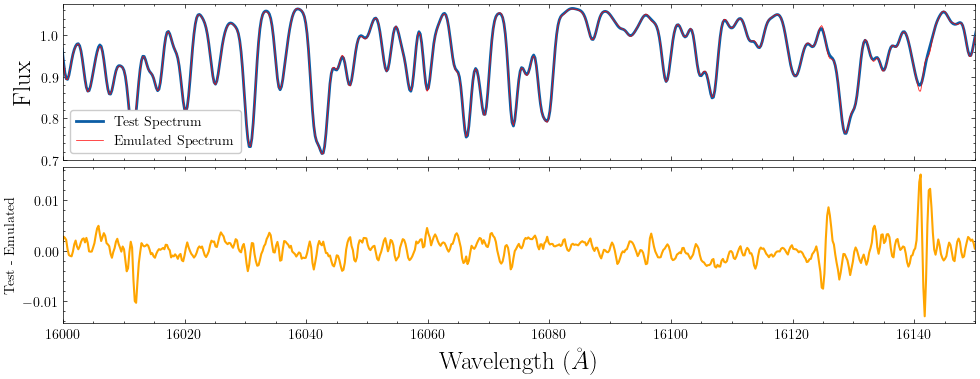

,Label,Predicted,True,Residual
0,Teff,3554.4931,3562.0000,-7.5069
1,Logg,1.2350,1.3500,-0.1150
2,Vturb,1.1516,1.1884,-0.0368
3,[C/H],-0.2069,-0.1422,-0.0647
4,[N/H],-0.5379,-0.6043,0.0664
5,[O/H],-0.0197,-0.0053,-0.0144
6,[Na/H],-0.7514,-0.6460,-0.1053
7,[Mg/H],-0.1876,-0.1947,0.0071
8,[Al/H],-0.2436,-0.2255,-0.0181
9,[Si/H],-0.2321,-0.2263,-0.0059


In [29]:
fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(nrows=2, ncols=1)
ax1 = fig.add_subplot(gs[0]); ax2 = fig.add_subplot(gs[1])
ax1.plot(wavelength, validation_spectra[idx], lw=2, label='Test Spectrum')
ax1.plot(wavelength, model_spec, lw=0.5, label='Emulated Spectrum', c='r')
    
lambda_min, lambda_max = 16000, 16150
ax1.set_ylim(0.7, 1.075)
ax1.legend(framealpha=1, frameon=1)
ax1.set_ylabel('Flux', fontsize=fs); ax1.set_xticklabels([])
ax2.plot(wavelength, validation_spectra[idx] - model_spec, c='orange', lw=1.5)
ax2.set_xlabel('Wavelength ($\AA$)', fontsize=fs); ax2.set_ylabel('Test - Emulated')
[ax.set_xlim(lambda_min, lambda_max) for ax in [ax1, ax2]]; plt.tight_layout(h_pad=0) ; plt.show()
pd.DataFrame({
    "Label": label_names[:-1],
    "Predicted": popt[:-1],
    "True": validation_labels[idx],
    "Residual": popt[:-1] - validation_labels[idx]
}).round(4)

Understandably, the method performs well on data of similar quality.

## Comparison between emulators

Let's compare the predictive properties of the *The Cannon* versus *The Payne*, predicting only on $T_{\mathrm{eff}}$, $\log$ (g), and [Fe/H]. First let us train a model of *The Cannon*, drawing from the methods outlined in the previous section.

In [32]:
from TheCannon import dataset

## Initialize a Dataset using the training and validation spectra ##
ds_payne = dataset.Dataset(wavelength, np.ones(len(training_labels)),
                           training_spectra, 40000*np.ones_like(training_spectra), training_labels[:,[0,1,18]],
                     np.ones(len(validation_labels)), validation_spectra, 40000*np.ones_like(validation_spectra))
ds_payne.set_label_names(['T_{eff}', '\log g', '[Fe/H]'])

## Determine pseudo-continuum ##
pseudo_tr_flux, pseudo_tr_ivar = ds_payne.continuum_normalize_training_q(q=0.90, delta_lambda=50,
                                                                  verbose=False)

## Make a continuum mask, fit continuum, and normalize spectra ##
contmask = ds_payne.make_contmask(pseudo_tr_flux, pseudo_tr_ivar, frac=0.07)
ds_payne.set_continuum(contmask)
cont = ds_payne.fit_continuum(2, "chebyshev") 
norm_train_flux, norm_train_ivar, norm_test_flux, norm_test_ivar = ds_payne.continuum_normalize(cont)

Loading dataset
This may take a while...
Continuum normalizing the tr set using running quantile...
##########################################################
@Bo Zhang: you will use only 1 process ...
           i.e., the original TheCannon version
##########################################################


In [34]:
from TheCannon import model

## Training The Cannon ##

md = model.CannonModel(2, False)
md.fit(ds_payne)

Done training model. 


Next, let's train a model of *The Payne* using the same training spectra used to train *The Cannon*.

In [ ]:
from The_Payne import training

## Training The Payne ##

training.neural_net(training_labels[:,[0,1,18]], training_spectra,\
                    validation_labels[:,[0,1,18]], validation_spectra,\
                    num_neurons=300, learning_rate=1e-4,\
                    num_steps=1e4, batch_size=128)

### Comparison of validation performance

Let's first see the performance from *The Cannon*. 

In [42]:
errs, chisq = md.infer_labels(ds_payne)

Inferring Labels


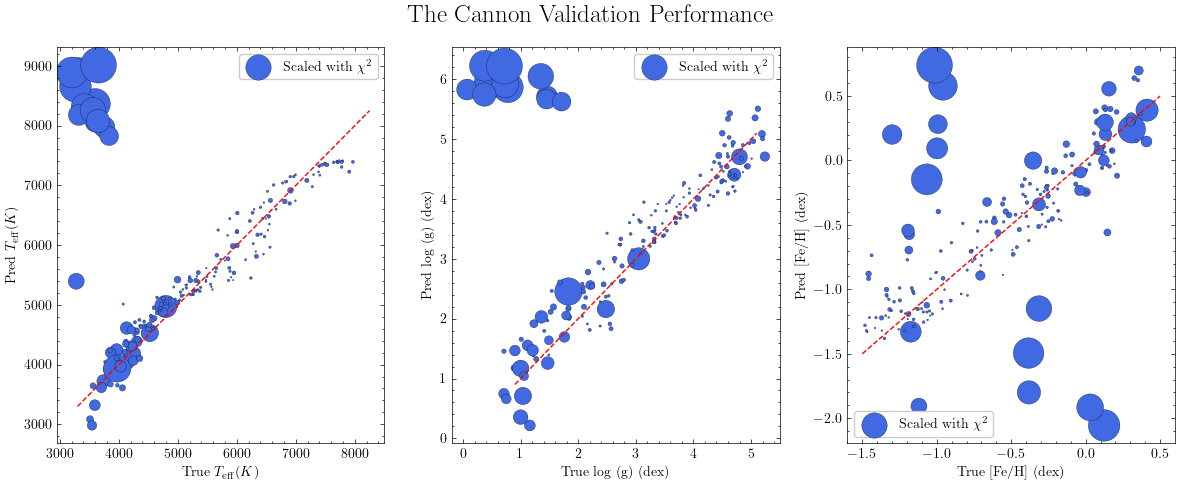

In [45]:
fig = plt.figure(figsize=(12,5))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
axlist = [ax1, ax2, ax3]
bounds = [[3300, 8250], [0.9, 5.1], [-1.5, 0.5]]
plot_labels = ['$T_{\mathrm{eff}} (K)$', '$\log$ (g) (dex)', '[Fe/H] (dex)']

for i, ax in enumerate(axlist):   
    ax.scatter(validation_labels[:,[0,1,18]][:,i], ds_payne.test_label_vals[:,i], c='royalblue', lw=0.2,
               s=chisq/250., edgecolor='k', label='Scaled with $\\chi^2$')
    ax.plot(bounds[i], bounds[i], c='red', ls='--')
    ax.legend(framealpha=1, frameon=True)
    ax.set_ylabel(f'Pred {plot_labels[i]}')
    ax.set_xlabel(f'True {plot_labels[i]}')
plt.suptitle('The Cannon Validation Performance', fontsize=fs)
plt.tight_layout(h_pad=1)

While we find reasonable agreement with the ground truth, there is a clear population of outliers for which the spectra predicted by *The Cannon* is strongly discrepant (high $\chi^2$). Let's view several of these. 

In [49]:
md.infer_spectra(ds_payne)
pred_flux = md.model_spectra

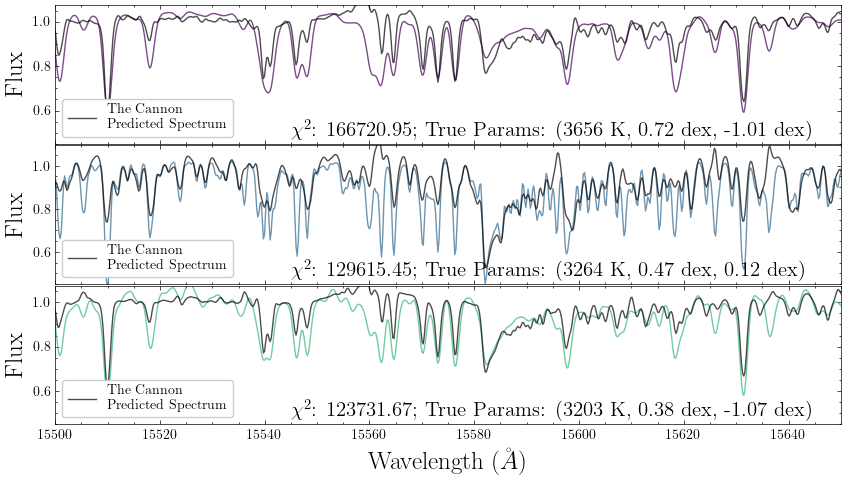

In [79]:
fig = plt.figure(figsize=(9, 5))
ax1, ax2, ax3 = fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)
axlist = [ax1, ax2, ax3]
idxes = np.argsort(chisq)[::-1][[0, 1, 2]]
cmap = plt.cm.viridis 
norm = colors.Normalize(vmin=0, vmax=len(idxes))
ax1.set_ylim(0.45, 1.075)
ax2.set_ylim(0.45, 1.095)
ax3.set_ylim(0.45, 1.075)

for i, (idx,ax) in enumerate(zip(idxes,axlist)):
    plot_flux = norm_test_flux[idx]
    cond = (plot_flux > 0) & (norm_test_ivar[idx] > 0)
    ax.plot(wavelength[cond], plot_flux[cond], color=cmap(norm(i)), alpha=0.7)
    ax.plot(wavelength[cond], pred_flux[idx][cond], color='k', alpha=0.7, label='The Cannon\nPredicted Spectrum')

    ax.set_xlim(15500, 15650)

    ax.set_ylabel('Flux', fontsize=fs)
    if i == (len(axlist) - 1):
        ax.set_xlabel('Wavelength ($\AA$)', fontsize=fs)
    else:
        ax.set_xticklabels([])
    ax.text(x=0.3, y=0.06, s=f'$\\chi^2$: {chisq[idx]:.2f}; True Params: ({validation_labels[idx,[0,1,18]][0]:.0f} K, {validation_labels[idx,[0,1,18]][1]:.2f} dex, {validation_labels[idx,[0,1,18]][2]:.2f} dex)', transform=ax.transAxes, fontsize=fs-3)
    ax.legend(loc='lower left', frameon=1, framealpha=1)
plt.tight_layout(h_pad=0.1); plt.show()

The low temperatures of the stars, combined with our visual inspection of the reconstruction fidelity, suggests that the method struggles with complex spectra, dense with many spectral lines. This was previously seen in [](content:references:spectra_part2) as well!

Now let's see *The Payne*'s performance:

In [39]:
## Loading in The Payne weights from the training session ##

saved_weights = np.load(str(data_folder_path) + "/NN_normalized_spectra.npz")
for name in list(saved_weights.keys()):
    globals()[name + '_trained'] = saved_weights[name] 
NN_coeffs_trained = w_array_0_trained, w_array_1_trained,\
             w_array_2_trained , b_array_0_trained,\
             b_array_1_trained, b_array_2_trained, x_min_trained,\
             x_max_trained

## Running predictions over the validation set with The Payne ##

payne_val_labels = []
for idx in range(len(validation_spectra)):
    popt, _, _ = fitting.fit_normalized_spectrum_single_star_model(\
                                    norm_spec = validation_spectra[idx], spec_err = 1e-2*np.ones(len(wavelength)),\
                                    NN_coeffs = NN_coeffs_trained, wavelength = wavelength, mask=mask, p0 = None)
    payne_val_labels.append(popt)
payne_val_labels = np.array(payne_val_labels)

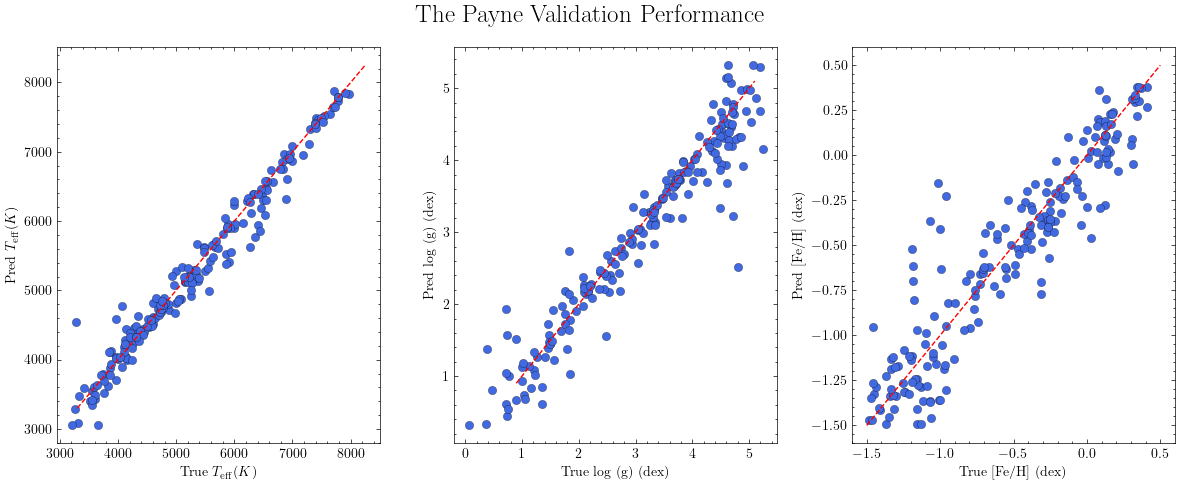

In [44]:
fig = plt.figure(figsize=(12,5))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
axlist = [ax1, ax2, ax3]
bounds = [[3300, 8250], [0.9, 5.1], [-1.5, 0.5]]
plot_labels = ['$T_{\mathrm{eff}} (K)$', '$\log$ (g) (dex)', '[Fe/H] (dex)']

for i, ax in enumerate(axlist):   
    ax.scatter(validation_labels[:,[0,1,18]][:,i], payne_val_labels[:,i], c='royalblue', lw=0.2, edgecolor='k', label='Scaled with $\\chi^2$')
    ax.plot(bounds[i], bounds[i], c='red', ls='--')
    ax.set_ylabel(f'Pred {plot_labels[i]}')
    ax.set_xlabel(f'True {plot_labels[i]}')
plt.suptitle('The Payne Validation Performance', fontsize=fs)
plt.tight_layout(h_pad=1)

*The Payne* provides a much better one-to-one agreement with the validation labels, even at low temperatures. Let's take a look at how well it reconstructs the same examples for which *The Cannon*'s predictions were highly discrepant.

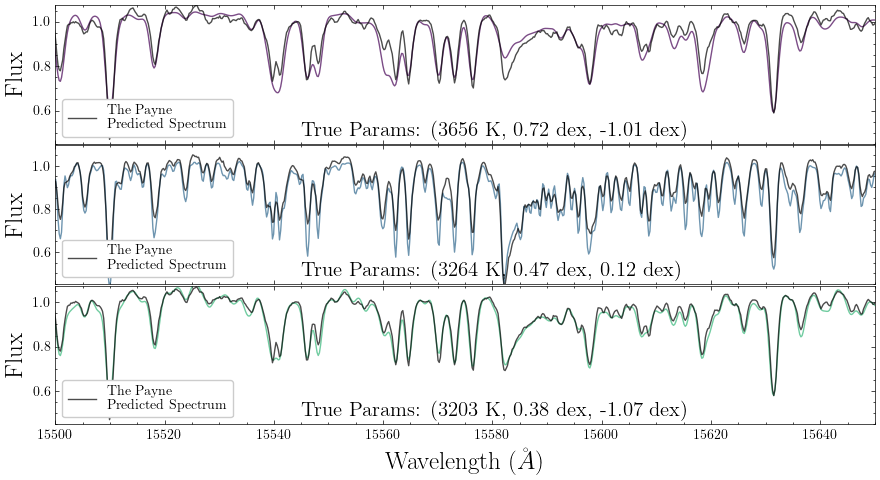

In [84]:
fig = plt.figure(figsize=(9, 5))
ax1, ax2, ax3 = fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)
axlist = [ax1, ax2, ax3]
idxes = np.argsort(chisq)[::-1][[0, 1, 2]]
cmap = plt.cm.viridis 
norm = colors.Normalize(vmin=0, vmax=len(idxes))
ax1.set_ylim(0.45, 1.075)
ax2.set_ylim(0.45, 1.095)
ax3.set_ylim(0.45, 1.075)

for i, (idx,ax) in enumerate(zip(idxes,axlist)):
    plot_flux = norm_test_flux[idx]
    pred_labels = payne_val_labels[idx]
    pred_scaled_labels = (pred_labels[:-1]  - x_min_trained) / (x_max_trained - x_min_trained) - 0.5 
    pred_spec = spectral_model.get_spectrum_from_neural_net(
            scaled_labels=pred_scaled_labels, NN_coeffs=NN_coeffs_trained)
    pred_spec = utils.doppler_shift(wavelength, pred_spec, pred_labels[-1])
    
    ax.plot(wavelength, plot_flux, color=cmap(norm(i)), alpha=0.7)
    ax.plot(wavelength, pred_spec, color='k', alpha=0.7, label='The Payne\nPredicted Spectrum')

    ax.set_xlim(15500, 15650)

    ax.set_ylabel('Flux', fontsize=fs)
    if i == (len(axlist) - 1):
        ax.set_xlabel('Wavelength ($\AA$)', fontsize=fs)
    else:
        ax.set_xticklabels([])
    ax.text(x=0.3, y=0.06, s=f'True Params: ({validation_labels[idx,[0,1,18]][0]:.0f} K, {validation_labels[idx,[0,1,18]][1]:.2f} dex, {validation_labels[idx,[0,1,18]][2]:.2f} dex)', transform=ax.transAxes, fontsize=fs-3)
    ax.legend(loc='lower left', frameon=1, framealpha=1)
plt.tight_layout(h_pad=0.1); plt.show()

The greater flexibility of *The Payne* naturally allows per-pixel flux variations to be modeled and reconstructed with higher fidelity.

## Overfitting from Model Capacity 

Given this increased flexibility of *The Payne* over *The Cannon*, is the method more prone to overfitting? Let's have a cursory analysis from the in-built tools from each repository.

In [85]:
from scipy import optimize as opt
from TheCannon.infer_labels import _func, _get_lvec

## Hacky way of getting chisq for both training and validation set from the repo ##

def cannon_infer_labels(model, dataset, input_flux, input_ivars):
    coeffs_all = model.coeffs
    scatters = model.scatters
    nlabels = len(dataset.get_plotting_labels())
    fluxes = input_flux
    ivars = input_ivars
    nstars = fluxes.shape[0]
    labels_all = np.zeros((nstars, nlabels))
    MCM_rotate_all = np.zeros((nstars, coeffs_all.shape[1] - 1,
                               coeffs_all.shape[1] - 1))
    errs_all = np.zeros((nstars, nlabels))
    chisq_all = np.zeros(nstars)
    scales = model.scales

    starting_guess = np.ones(nlabels)
    for jj in range(nstars):
        flux = fluxes[jj,:]
        ivar = ivars[jj,:]

        # where the ivar == 0, set the normalized flux to 1 and the sigma to 100
        bad = ivar == 0
        flux[bad] = 1.0
        sigma = np.ones(ivar.shape) * 100.0
        sigma[~bad] = np.sqrt(1.0 / ivar[~bad])

        flux_piv = flux - coeffs_all[:,0] * 1.  # pivot around the leading term
        errbar = np.sqrt(sigma**2 + scatters**2)
        coeffs = np.delete(coeffs_all, 0, axis=1)  # take pivot into account
        
        try:
            labels, covs = opt.curve_fit(_func, coeffs, flux_piv,
                                         p0 = starting_guess,
                                         sigma=errbar, absolute_sigma=True)
        except RuntimeError:
            print("Error - curve_fit failed")
            labels = np.zeros(starting_guess.shape)-9999.
            covs = np.zeros((len(starting_guess),len(starting_guess)))-9999.
        chi2 = (flux_piv-_func(coeffs, *labels))**2 * ivar / (1 + ivar * scatters**2)
        chisq_all[jj] = sum(chi2)
        labels_all[jj,:] = model.scales * labels + model.pivots
        errs_all[jj,:] = np.sqrt(covs.diagonal())

    return labels_all, chisq_all

_, train_chisq = cannon_infer_labels(md, ds_payne, 
                                                    training_spectra, 40000*np.ones_like(training_spectra))
_, val_chisq = cannon_infer_labels(md, ds_payne, validation_spectra, 40000*np.ones_like(validation_spectra))

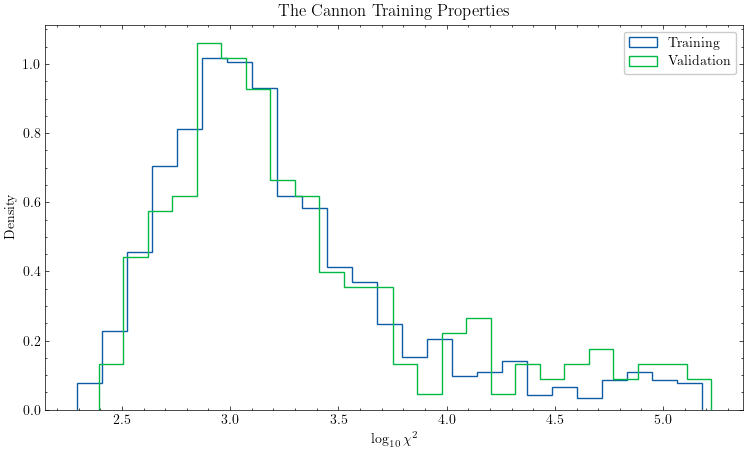

In [91]:
fig = plt.figure(figsize=(9, 5))
ax1 = fig.add_subplot(111)
ax1.set_title('The Cannon Training Properties')
ax1.hist(np.log10(train_chisq), bins=25, histtype='step', density=True, label='Training')
ax1.hist(np.log10(val_chisq), bins=25, histtype='step', density=True, label='Validation')
ax1.legend(frameon=1,framealpha=1)
ax1.set_ylabel('Density'); ax1.set_xlabel('$\\log_{10} \\chi^2 $')
plt.show()

The comparable errors observed in both the training and validation sets of The Cannon indicate that the model is not overfitting. Instead, its limited ability to accurately reconstruct the spectra likely stems from insufficient model capacity, rather than poor generalization.

Text(0, 0.5, 'Loss')

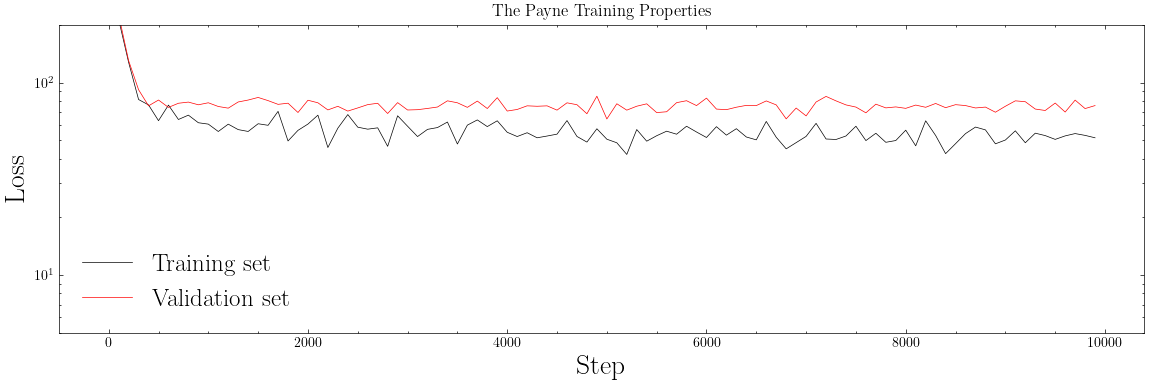

In [90]:
tmp = np.load(str(data_folder_path) + "/training_loss.npz") # the output array also stores the training and validation loss
training_loss = tmp["training_loss"]
validation_loss = tmp["validation_loss"]

plt.figure(figsize=(14, 4))
plt.plot(np.arange(training_loss.size)*100, training_loss, 'k', lw=0.5, label = 'Training set')
plt.plot(np.arange(training_loss.size)*100, validation_loss, 'r', lw=0.5, label = 'Validation set')
plt.legend(loc = 'best', frameon = False, fontsize= 18)
plt.title('The Payne Training Properties')
plt.yscale('log')
plt.ylim([5,200])
plt.xlabel("Step", size=20)
plt.ylabel("Loss", size=20)

Conversely, *The Payne*, with its increased model capacity as a two-layer perceptron, shows indication of overfitting in its training.

`````{admonition} Exercise
1. Repeat the fitting to both *The Payne* and *The Cannon*, but include elemental abundances instead of only global stellar parameters. What is the performance of either method? Which is more prone to overfit?

2. A weakness of *The Cannon* is that it assumes each pixel varies independently of others, when there is clearly a correlation between flux values at wavelengths where spectral features arise. Does *The Payne* solve this issue? Otherwise, what kind of enhancements could one apply to the network to impose this constraint?

`````